In [303]:
# Class dependencies
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
from models.folds import Fold, SoftFold
from models.model_bank import DynamicOrigami, Softmax
from models.training import train, NoamScheduler, load_data, plot_model
from torch.utils.data import Dataset, DataLoader



# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from sklearn.datasets import load_digits

In [304]:
# import small digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# set up the model
# model = OrigamiNetwork(layers=1, epochs=300, optimizer='sgd',learning_rate=0.001, sigmoid=True, crease=5)
# model.fit(X_train, y_train, X_val, y_val)

# # get the predictions
# y_hat = model.predict(X_test)
# print(accuracy_score(y_test, y_hat))

In [305]:
architecture = [{'type': 'SoftFold', 'params': {'width':64, 'has_stretch': False}},
                {'type': 'SoftFold', 'params': {'width':70, 'has_stretch': False}},
                {'type': 'SoftFold', 'params': {'width':80, 'has_stretch': False}},
                {'type': 'SoftFold', 'params': {'width':90, 'has_stretch': False}},
                {'type': 'SoftFold', 'params': {'width':100, 'has_stretch': False}}]

architecture2 = [{'type': 'SoftFold', 'params': {'width':100, 'has_stretch': False}}]

In [306]:
# Data generation
train_loader = load_data(X_train, y_train, batch_size=32, shuffle=True)
val_loader = load_data(X_val, y_val, batch_size=32, shuffle=True)
test_loader = load_data(X_test, y_test, batch_size=32, shuffle=True)

Working Device: cpu


epoch:300/300, batch: 36/36, loss:0.0402: 100%|██████████| 10800/10800 [00:15<00:00, 701.91it/s]


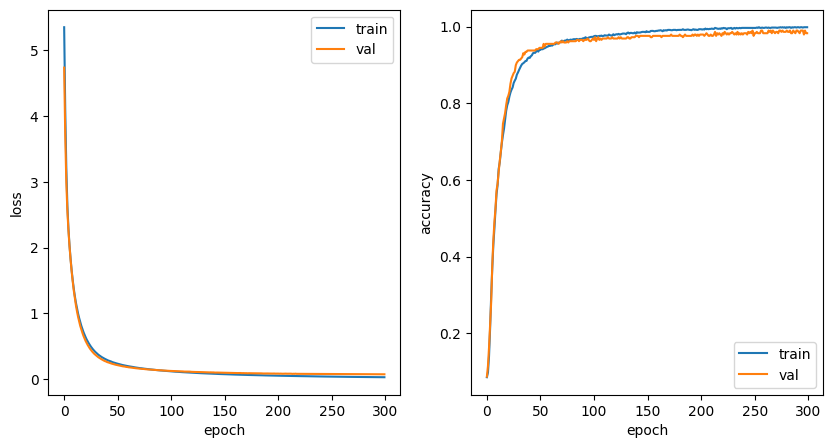

final val_score: 0.9895833333333334


In [307]:
model = DynamicOrigami(architecture,10)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, train_loader, val_loader, epochs=300)
plot_model(train_losses, val_losses, train_accuracies, val_accuracies)
print("final val_score:", np.mean(val_accuracies[-10]))

Working Device: cpu


epoch:300/300, batch: 36/36, loss:0.0165: 100%|██████████| 10800/10800 [00:09<00:00, 1199.38it/s]


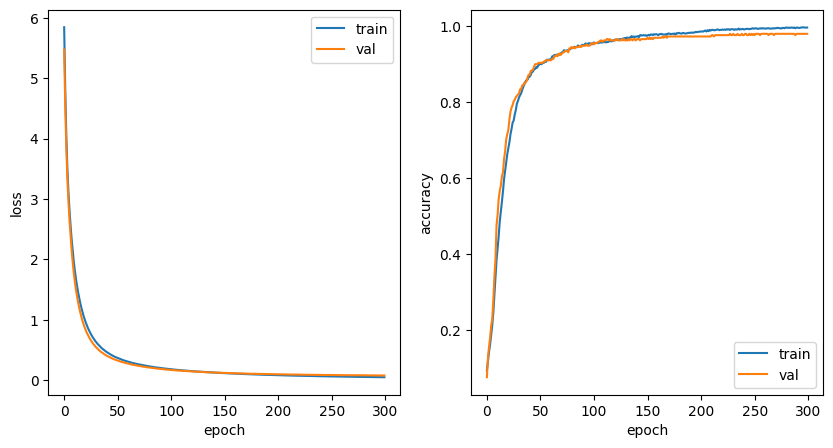

final val_score: 0.9791666666666666


In [308]:
model2 = DynamicOrigami(architecture2,10)
optimizer = torch.optim.Adam(model2.parameters(), lr=.0001)
train_losses, val_losses, train_accuracies, val_accuracies = train(model2, optimizer, train_loader, val_loader, epochs=300)
plot_model(train_losses, val_losses, train_accuracies, val_accuracies)
print("final val_score:", np.mean(val_accuracies[-10]))

In [309]:
# print out all stretch and crease parameters
for layer in model.layers:
    if isinstance(layer, SoftFold):
        # print the layer number
        print(f'Layer {layer}')
        print(f'Crease: {layer.crease.data[0]}')
        print(f'Stretch: {layer.stretch.data}')
        print()

n_vectors = []
a_values = []
stretch_values = []
# print the norm of the fold parameters
for layer in model.layers:
    if isinstance(layer, SoftFold):
        print(torch.norm(layer.n).item())
        n_vectors.append(layer.n.detach().numpy())
        a_values.append(layer.crease.detach().numpy())
        stretch_values.append(layer.stretch.detach().numpy())

linear = model.layers[-1]
weights = linear.weight.detach().numpy()

Layer SoftFold()
Crease: -1.5901776552200317
Stretch: 2.0

Layer SoftFold()
Crease: -0.6160607933998108
Stretch: 2.0

Layer SoftFold()
Crease: 0.33315789699554443
Stretch: 2.0

Layer SoftFold()
Crease: 0.960559606552124
Stretch: 2.0

Layer SoftFold()
Crease: 1.7586315870285034
Stretch: 2.0

1.32813560962677
1.422472596168518
1.3485649824142456
1.2690033912658691
1.379572868347168


ValueError: cannot reshape array of size 70 into shape (8,8)

<Figure size 2000x1000 with 0 Axes>

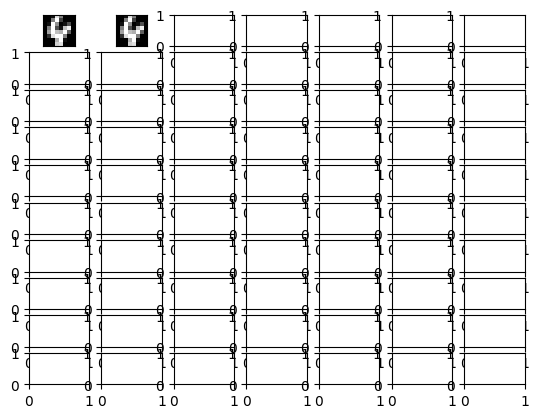

In [310]:
# # display each of the n vectors in grayscale
# # make the figure larger
# plt.figure(figsize=(20, 10))
# fig, axs = plt.subplots(1, len(n_vectors))
# for i, n in enumerate(n_vectors):
#     axs[i].imshow(n.reshape(8, 8), cmap='gray')
#     axs[i].axis('off')
# plt.show()

# # plot similar noise vectors
# noise = np.random.normal(0, 1, (len(n_vectors), 64))
# plt.figure(figsize=(20, 10))
# fig, axs = plt.subplots(1, len(n_vectors))
# for i, n in enumerate(noise):
#     axs[i].imshow(n.reshape(8, 8), cmap='gray')
#     axs[i].axis('off')
# plt.show()

# # get a single sample of the data and print it
# import numpy as np

# import numpy as np

def soft_folding_transform(alpha, stretch, x, n):
    """
    Performs a soft folding transformation on the 1D input vector x using given parameters.
    
    Args:
        alpha (float): The crease parameter used in the transformation.
        stretch (float): The stretch parameter to scale the orthogonal projection.
        x (np.ndarray): The input vector of shape (input_dim,).
        n (np.ndarray): The normal vector of shape (input_dim,).

    Returns:
        np.ndarray: The transformed vector of shape (input_dim,).
    """
    if n.shape[0] > x.shape[0]:
        x = np.pad(x, (0, n.shape[0] - x.shape[0]), mode='constant')
    elif n.shape[0] < x.shape[0]:
        raise ValueError(f"Input dimension ({x.shape[0]}) is greater than fold width ({n.shape[0]})")

    # Small epsilon for numerical stability
    eps = 1e-8

    # Compute z_dot_x, n_dot_n, and scales
    z_dot_x = np.dot(x, n)  # Scalar result
    n_dot_n = np.dot(n, n) + eps  # Scalar result
    scale = z_dot_x / n_dot_n

    # Compute 'p' and sigmoid
    p = alpha * (z_dot_x - n_dot_n)
    p = np.clip(p, -25.0, 25.0)
    sigmoid = 1 / (1 + np.exp(-p))  # Sigmoid function, scalar

    # Compute the orthogonal projection and the output
    ortho_proj = (1 - scale) * n  # shape: (input_dim,)
    output = x + stretch * sigmoid * ortho_proj  # shape: (input_dim,)
    return output



size = 10
plt.figure(figsize=(20, 10))
fig, axs = plt.subplots(size, len(a_values) + 2)
for j in range(size):
    sample = X_train[j]
    transforms = [sample]
    for i, (a, s, n) in enumerate(zip(a_values, stretch_values, n_vectors)):
        sample = soft_folding_transform(a[0], s, sample, n)
        transforms.append(sample)
    # Add the linear transformation
    sample = np.dot(weights, sample)
    transforms.append(sample)
    for i, t in enumerate(transforms):
        if i == len(transforms) - 1:
            axs[j, i].imshow(t.reshape(10, 1), cmap='gray')
        else:
            axs[j, i].imshow(t.reshape(8, 8), cmap='gray')
        #axs[j, i].axis('off')
        # put a border around all the images
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        
        
plt.show()
plt.tight_layout()

